In [1]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
log = logging.getLogger(__name__)

In [36]:
from timeit import default_timer
from datetime import timedelta


class Timer(object):
    """Timer class.

    `Original code <https://github.com/miguelgfierro/pybase/blob/2298172a13fb4a243754acbc6029a4a2dcf72c20/log_base/timer.py>`_.
    
    """

    def __init__(self):
        self._timer = default_timer
        self._interval = 0
        self.running = False

    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def __str__(self):
        return "{:0.4f}".format(self.interval)

    def start(self):
        """Start the timer."""
        self.init = self._timer()
        self.running = True

    def stop(self):
        """Stop the timer. Calculate the interval in seconds."""
        self.end = self._timer()
        try:
            self._interval = self.end - self.init
            self.running = False
        except AttributeError:
            raise ValueError(
                "Timer has not been initialized: use start() or the contextual form with Timer() as t:"
            )

    @property
    def interval(self):
        """Get time interval in seconds.

        Returns:
            float: Seconds.
        """
        if self.running:
            raise ValueError("Timer has not been stopped, please use stop().")
        else:
            return self._interval

In [38]:
from pmaw import PushshiftAPI as PMAW
from psaw import PushshiftAPI as PSAW

In [103]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import pprint

class Benchmark(object):
    """Run benchmarks on psaw and pmaw"""
    def __init__(self, num_limits, sleep, subreddit, jitters, limit_types, base_limit=5,):
        self.api_timing = []
        self.sleep = sleep
        self.subreddit = subreddit
        
        self._set_limits(num_limits, base_limit)
        self._gen_options(jitters, limit_types)      
    
    def plot(self, plot_type='line'):
        timing_df = pd.DataFrame(self.api_timing)
        # create name columns
        names = []
        for row in timing_df.itertuples():
            names.append(f'{row.api}-{row.limit_type}:{row.jitter}::{row.iter}')     
        timing_df['name'] = names
        names = timing_df['name'].unique()
        # create plot
        if plot_type == 'line':
            fig, axes = plt.subplots()

            fig.set_figheight(10)
            fig.set_figwidth(15)

            for name in names:
                x = timing_df.loc[timing_df['name']== name, 'limit']
                y = timing_df.loc[timing_df['name']== name, 'time']
                line, = axes.plot(x, y, label=name)
            plt.title('PMAW vs PSAW Completion Time Comparison', fontsize=15)
            plt.xlabel('Number of Requested Posts')
            plt.ylabel('Completion Time (s)')
            axes.legend()
            plt.show()
    
    def store_timing(self, filename):
        print(f'Saving {len(self.api_timing)} API times to {filename}.csv')
        pd.DataFrame(self.api_timing).to_csv(f'{filename}.csv')
    
    def _reset(self):
        self.api_timing = []
    
    def _set_limits(self, num_limits, base_limit=5):
        self.limits = [base_limit**i for i in range(num_limits)]
        print(f'Set {len(self.limits)} Limits:')
        pprint.pprint(self.limits)
        
    def _gen_options(self, jitters, limit_types):
        self.options = []
        # generate pmaw options
        ## generate different backoff types
        self.options.extend([{'api': 'pmaw', 'limit': limit, 'limit_type': ratelimit, 'jitter': jitter} 
                             for limit in self.limits for ratelimit in limit_types for jitter in jitters 
                             if ratelimit =='backoff'])
        ## generate options for rate averaging
        self.options.extend([{'api': 'pmaw', 'limit': limit, 'limit_type': ratelimit, 'jitter': None} 
                             for limit in self.limits for ratelimit in limit_types if ratelimit == 'average'])
        
        # generate psaw options
        self.options.extend([{'api': 'psaw', 'limit': limit, 'limit_type': 'default', 'jitter': None} 
                             for limit in self.limits])
        print(f'Generated {len(self.options)} Options:')
        pprint.pprint(self.options)
        
    def run(self, num_runs):
        print(f'Running {num_runs} tests with {len(self.options)} different options configurations')
        for i in range(num_runs):
            for option in self.options:
                self._call(option, i)
                print(f'\nSleeping {self.sleep}s\n')
                time.sleep(self.sleep)
                
    def _call(self, option, iteration):
        api = option['api']
        limit = option['limit']
        limit_type = option['limit_type']
        jitter = option['jitter']
        
        print(f'Run {iteration}: {api} - limit {limit} - limit_type {limit_type} - jitter {jitter}')
        with Timer() as t:
            if api =='pmaw':
                pmaw = PMAW(limit_type=limit_type, jitter=jitter)
                results = pmaw.search_submissions(subreddit=self.subreddit, limit=limit)
            else:
                psaw = PSAW()
                gen = psaw.search_submissions(subreddit=self.subreddit, limit=limit)
                results = [post for post in gen]
        self.api_timing.append({'api': api, 'time': t.interval, 'limit': limit, 'results': len(results), 
                           'limit_type': limit_type, 'jitter': jitter, 'iter': iteration})
        print(f'Done {iteration}: {api} -- {len(results)} results in {t}s : limit {limit} - limit_type {limit_type} - jitter {jitter}')

In [69]:
jitters = [None,'full', 'equal', 'decorr']
limit_types = ['average', 'backoff']
bench = Benchmark(num_limits=7, sleep=60, subreddit="science", jitters=jitters, limit_types=limit_types)

Set 7 Limits:
[1, 5, 25, 125, 625, 3125, 15625]
Generated 42 Options:
[{'api': 'pmaw', 'jitter': None, 'limit': 1, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'full', 'limit': 1, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'equal', 'limit': 1, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'decorr', 'limit': 1, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': None, 'limit': 5, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'full', 'limit': 5, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'equal', 'limit': 5, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'decorr', 'limit': 5, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': None, 'limit': 25, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'full', 'limit': 25, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'equal', 'limit': 25, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'decorr', 'limit': 25, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': None, 'limit': 125, 

In [70]:
bench.run(1)

Running 1 tests with 42 different options configurations
Run 0: pmaw - limit 1 - limit_type backoff - jitter None
811774 total results available for the selected parameters
Total Success Rate: 25.00% -- Total Reqs: 4 -- Total Batches: 1
Done 0: pmaw -- 1 results in 2.9532s : limit 1 - limit_type backoff - jitter None

Sleeping 60s

Run 0: pmaw - limit 1 - limit_type backoff - jitter full
811774 total results available for the selected parameters
Total Success Rate: 25.00% -- Total Reqs: 4 -- Total Batches: 1
Done 0: pmaw -- 1 results in 5.9715s : limit 1 - limit_type backoff - jitter full

Sleeping 60s

Run 0: pmaw - limit 1 - limit_type backoff - jitter equal
811774 total results available for the selected parameters
Total Success Rate: 25.00% -- Total Reqs: 4 -- Total Batches: 1
Done 0: pmaw -- 1 results in 3.2467s : limit 1 - limit_type backoff - jitter equal

Sleeping 60s

Run 0: pmaw - limit 1 - limit_type backoff - jitter decorr
811774 total results available for the selected par

Total Success Rate: 40.00% -- Total Reqs: 20 -- Total Batches: 2
Total Success Rate: 50.00% -- Total Reqs: 30 -- Total Batches: 3
Total Success Rate: 47.50% -- Total Reqs: 40 -- Total Batches: 4
Total Success Rate: 52.00% -- Total Reqs: 50 -- Total Batches: 5
Total Success Rate: 55.00% -- Total Reqs: 60 -- Total Batches: 6
Total Success Rate: 57.14% -- Total Reqs: 70 -- Total Batches: 7
Total Success Rate: 58.75% -- Total Reqs: 80 -- Total Batches: 8
Total Success Rate: 60.00% -- Total Reqs: 90 -- Total Batches: 9
Total Success Rate: 61.00% -- Total Reqs: 100 -- Total Batches: 10
Total Success Rate: 61.82% -- Total Reqs: 110 -- Total Batches: 11
Total Success Rate: 62.50% -- Total Reqs: 120 -- Total Batches: 12
Total Success Rate: 63.85% -- Total Reqs: 130 -- Total Batches: 13
Total Success Rate: 64.29% -- Total Reqs: 140 -- Total Batches: 14
Total Success Rate: 64.67% -- Total Reqs: 150 -- Total Batches: 15
Total Success Rate: 65.00% -- Total Reqs: 160 -- Total Batches: 16
Total Succe

Total Success Rate: 100.00% -- Total Reqs: 7 -- Total Batches: 1
Done 0: pmaw -- 625 results in 12.1118s : limit 625 - limit_type average - jitter None

Sleeping 60s

Run 0: pmaw - limit 3125 - limit_type average - jitter None
811785 total results available for the selected parameters
Total Success Rate: 100.00% -- Total Reqs: 10 -- Total Batches: 1
Total Success Rate: 95.00% -- Total Reqs: 20 -- Total Batches: 2
Total Success Rate: 96.67% -- Total Reqs: 30 -- Total Batches: 3
Total Success Rate: 96.97% -- Total Reqs: 33 -- Total Batches: 4
Done 0: pmaw -- 3125 results in 35.0381s : limit 3125 - limit_type average - jitter None

Sleeping 60s

Run 0: pmaw - limit 15625 - limit_type average - jitter None
811785 total results available for the selected parameters
Total Success Rate: 100.00% -- Total Reqs: 10 -- Total Batches: 1
Total Success Rate: 100.00% -- Total Reqs: 20 -- Total Batches: 2
Total Success Rate: 100.00% -- Total Reqs: 30 -- Total Batches: 3
Total Success Rate: 100.00% -- 

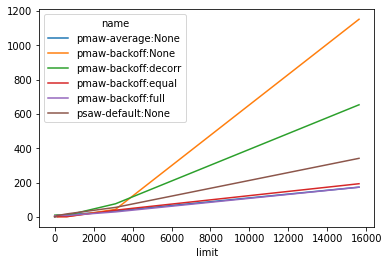

In [71]:
bench.plot()

In [72]:
bench.store_timing('01-ratelimitcomparison')

Saving 42 API times to 01-ratelimitcomparison.csv


In [77]:
timing_df = pd.DataFrame(bench.api_timing)

In [97]:
# create name columns
names = []
for row in timing_df.itertuples():
    names.append(f'{row.api}-{row.limit_type}:{row.jitter}::{row.iter}')     
timing_df['name'] = names
names = timing_df['name'].unique()

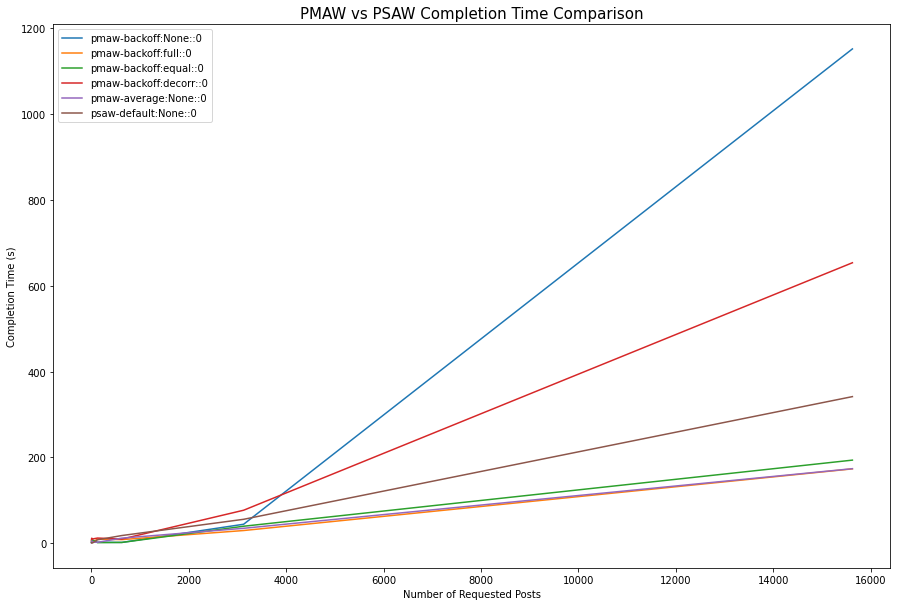

In [107]:
fig, axes = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)

for name in names:
    x = timing_df.loc[timing_df['name']== name, 'limit']
    y = timing_df.loc[timing_df['name']== name, 'time']
    line, = axes.plot(x, y, label=name)
plt.title('PMAW vs PSAW Completion Time Comparison', fontsize=15)
plt.xlabel('Number of Requested Posts')
plt.ylabel('Completion Time (s)')
axes.legend()
plt.show()

From the previous comparison we can see that the three most performant rate-limiting settings are the rate-averaging, and exponential backoff with full or equal jitter.

We run the comparison benchmark again with a higher number of posts requested, up to 390,000.

In [108]:
jitters = ['full', 'equal']
limit_types = ['average', 'backoff']
bench2 = Benchmark(num_limits=9, sleep=60, subreddit="science", jitters=jitters, limit_types=limit_types)

Set 9 Limits:
[1, 5, 25, 125, 625, 3125, 15625, 78125, 390625]
Generated 36 Options:
[{'api': 'pmaw', 'jitter': 'full', 'limit': 1, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'equal', 'limit': 1, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'full', 'limit': 5, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'equal', 'limit': 5, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'full', 'limit': 25, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'equal', 'limit': 25, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'full', 'limit': 125, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'equal', 'limit': 125, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'full', 'limit': 625, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'equal', 'limit': 625, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'full', 'limit': 3125, 'limit_type': 'backoff'},
 {'api': 'pmaw', 'jitter': 'equal', 'limit': 3125, 'limit_type': 'backoff'},
 {'api': 'pmaw', 

In [109]:
bench2.run(1)

Running 1 tests with 36 different options configurations
Run 0: pmaw - limit 1 - limit_type backoff - jitter full
811807 total results available for the selected parameters
Total Success Rate: 25.00% -- Total Reqs: 4 -- Total Batches: 1
Done 0: pmaw -- 1 results in 3.6032s : limit 1 - limit_type backoff - jitter full

Sleeping 60s

Run 0: pmaw - limit 1 - limit_type backoff - jitter equal
811807 total results available for the selected parameters
Total Success Rate: 25.00% -- Total Reqs: 4 -- Total Batches: 1
Done 0: pmaw -- 1 results in 3.4746s : limit 1 - limit_type backoff - jitter equal

Sleeping 60s

Run 0: pmaw - limit 5 - limit_type backoff - jitter full
811807 total results available for the selected parameters
Total Success Rate: 100.00% -- Total Reqs: 1 -- Total Batches: 1
Done 0: pmaw -- 5 results in 2.9739s : limit 5 - limit_type backoff - jitter full

Sleeping 60s

Run 0: pmaw - limit 5 - limit_type backoff - jitter equal
811807 total results available for the selected par

Run 0: pmaw - limit 78125 - limit_type backoff - jitter full
811807 total results available for the selected parameters
Total Success Rate: 70.00% -- Total Reqs: 10 -- Total Batches: 1
Total Success Rate: 45.00% -- Total Reqs: 20 -- Total Batches: 2
Total Success Rate: 53.33% -- Total Reqs: 30 -- Total Batches: 3
Total Success Rate: 57.50% -- Total Reqs: 40 -- Total Batches: 4
Total Success Rate: 62.00% -- Total Reqs: 50 -- Total Batches: 5
Total Success Rate: 68.33% -- Total Reqs: 60 -- Total Batches: 6
Total Success Rate: 67.14% -- Total Reqs: 70 -- Total Batches: 7
Total Success Rate: 61.25% -- Total Reqs: 80 -- Total Batches: 8
Total Success Rate: 60.00% -- Total Reqs: 90 -- Total Batches: 9
Total Success Rate: 61.00% -- Total Reqs: 100 -- Total Batches: 10
Total Success Rate: 61.82% -- Total Reqs: 110 -- Total Batches: 11
Total Success Rate: 65.00% -- Total Reqs: 120 -- Total Batches: 12
Total Success Rate: 63.08% -- Total Reqs: 130 -- Total Batches: 13
Total Success Rate: 60.00% 

Total Success Rate: 56.07% -- Total Reqs: 1220 -- Total Batches: 122
Total Success Rate: 56.42% -- Total Reqs: 1230 -- Total Batches: 123
Total Success Rate: 56.45% -- Total Reqs: 1240 -- Total Batches: 124
Total Success Rate: 56.08% -- Total Reqs: 1250 -- Total Batches: 125
Total Success Rate: 55.79% -- Total Reqs: 1260 -- Total Batches: 126
Total Success Rate: 55.75% -- Total Reqs: 1270 -- Total Batches: 127
Total Success Rate: 56.09% -- Total Reqs: 1280 -- Total Batches: 128
Total Success Rate: 55.97% -- Total Reqs: 1290 -- Total Batches: 129
Total Success Rate: 56.00% -- Total Reqs: 1300 -- Total Batches: 130
Total Success Rate: 55.73% -- Total Reqs: 1310 -- Total Batches: 131
Total Success Rate: 55.61% -- Total Reqs: 1320 -- Total Batches: 132
Total Success Rate: 55.71% -- Total Reqs: 1330 -- Total Batches: 133
Total Success Rate: 56.04% -- Total Reqs: 1340 -- Total Batches: 134
Total Success Rate: 55.93% -- Total Reqs: 1350 -- Total Batches: 135
Total Success Rate: 55.59% -- Tota

Total Success Rate: 50.96% -- Total Reqs: 830 -- Total Batches: 83
Total Success Rate: 51.55% -- Total Reqs: 840 -- Total Batches: 84
Total Success Rate: 51.18% -- Total Reqs: 850 -- Total Batches: 85
Total Success Rate: 50.70% -- Total Reqs: 860 -- Total Batches: 86
Total Success Rate: 50.34% -- Total Reqs: 870 -- Total Batches: 87
Total Success Rate: 50.68% -- Total Reqs: 880 -- Total Batches: 88
Total Success Rate: 51.24% -- Total Reqs: 890 -- Total Batches: 89
Total Success Rate: 51.22% -- Total Reqs: 900 -- Total Batches: 90
Total Success Rate: 50.88% -- Total Reqs: 910 -- Total Batches: 91
Total Success Rate: 50.65% -- Total Reqs: 920 -- Total Batches: 92
Total Success Rate: 50.86% -- Total Reqs: 930 -- Total Batches: 93
Total Success Rate: 51.17% -- Total Reqs: 940 -- Total Batches: 94
Total Success Rate: 51.68% -- Total Reqs: 950 -- Total Batches: 95
Total Success Rate: 51.98% -- Total Reqs: 960 -- Total Batches: 96
Total Success Rate: 51.55% -- Total Reqs: 970 -- Total Batches

Total Success Rate: 58.97% -- Total Reqs: 290 -- Total Batches: 29
Total Success Rate: 57.67% -- Total Reqs: 300 -- Total Batches: 30
Total Success Rate: 58.71% -- Total Reqs: 310 -- Total Batches: 31
Total Success Rate: 58.44% -- Total Reqs: 320 -- Total Batches: 32
Total Success Rate: 59.39% -- Total Reqs: 330 -- Total Batches: 33
Total Success Rate: 60.59% -- Total Reqs: 340 -- Total Batches: 34
Total Success Rate: 60.29% -- Total Reqs: 350 -- Total Batches: 35
Total Success Rate: 59.17% -- Total Reqs: 360 -- Total Batches: 36
Total Success Rate: 59.19% -- Total Reqs: 370 -- Total Batches: 37
Total Success Rate: 58.95% -- Total Reqs: 380 -- Total Batches: 38
Total Success Rate: 59.49% -- Total Reqs: 390 -- Total Batches: 39
Total Success Rate: 60.50% -- Total Reqs: 400 -- Total Batches: 40
Total Success Rate: 60.00% -- Total Reqs: 410 -- Total Batches: 41
Total Success Rate: 59.05% -- Total Reqs: 420 -- Total Batches: 42
Total Success Rate: 58.14% -- Total Reqs: 430 -- Total Batches

Total Success Rate: 58.93% -- Total Reqs: 1500 -- Total Batches: 150
Total Success Rate: 58.68% -- Total Reqs: 1510 -- Total Batches: 151
Total Success Rate: 58.42% -- Total Reqs: 1520 -- Total Batches: 152
Total Success Rate: 58.37% -- Total Reqs: 1530 -- Total Batches: 153
Total Success Rate: 58.64% -- Total Reqs: 1540 -- Total Batches: 154
Total Success Rate: 58.77% -- Total Reqs: 1550 -- Total Batches: 155
Total Success Rate: 58.53% -- Total Reqs: 1560 -- Total Batches: 156
Total Success Rate: 58.28% -- Total Reqs: 1570 -- Total Batches: 157
Total Success Rate: 58.16% -- Total Reqs: 1580 -- Total Batches: 158
Total Success Rate: 58.30% -- Total Reqs: 1590 -- Total Batches: 159
Total Success Rate: 58.56% -- Total Reqs: 1600 -- Total Batches: 160
Total Success Rate: 58.57% -- Total Reqs: 1610 -- Total Batches: 161
Total Success Rate: 58.33% -- Total Reqs: 1620 -- Total Batches: 162
Total Success Rate: 58.10% -- Total Reqs: 1630 -- Total Batches: 163
Total Success Rate: 58.23% -- Tota

Total Success Rate: 58.03% -- Total Reqs: 2690 -- Total Batches: 269
Total Success Rate: 58.00% -- Total Reqs: 2700 -- Total Batches: 270
Total Success Rate: 58.04% -- Total Reqs: 2710 -- Total Batches: 271
Total Success Rate: 57.98% -- Total Reqs: 2720 -- Total Batches: 272
Total Success Rate: 58.13% -- Total Reqs: 2730 -- Total Batches: 273
Total Success Rate: 58.18% -- Total Reqs: 2740 -- Total Batches: 274
Total Success Rate: 58.04% -- Total Reqs: 2750 -- Total Batches: 275
Total Success Rate: 57.90% -- Total Reqs: 2760 -- Total Batches: 276
Total Success Rate: 57.87% -- Total Reqs: 2770 -- Total Batches: 277
Total Success Rate: 58.02% -- Total Reqs: 2780 -- Total Batches: 278
Total Success Rate: 58.06% -- Total Reqs: 2790 -- Total Batches: 279
Total Success Rate: 57.93% -- Total Reqs: 2800 -- Total Batches: 280
Total Success Rate: 57.79% -- Total Reqs: 2810 -- Total Batches: 281
Total Success Rate: 57.73% -- Total Reqs: 2820 -- Total Batches: 282
Total Success Rate: 57.81% -- Tota

Total Success Rate: 57.06% -- Total Reqs: 3880 -- Total Batches: 388
Total Success Rate: 56.97% -- Total Reqs: 3890 -- Total Batches: 389
Total Success Rate: 57.00% -- Total Reqs: 3900 -- Total Batches: 390
Total Success Rate: 56.93% -- Total Reqs: 3910 -- Total Batches: 391
Total Success Rate: 56.89% -- Total Reqs: 3920 -- Total Batches: 392
Total Success Rate: 56.95% -- Total Reqs: 3930 -- Total Batches: 393
Total Success Rate: 57.06% -- Total Reqs: 3940 -- Total Batches: 394
Total Success Rate: 57.01% -- Total Reqs: 3950 -- Total Batches: 395
Total Success Rate: 56.89% -- Total Reqs: 3960 -- Total Batches: 396
Total Success Rate: 56.80% -- Total Reqs: 3970 -- Total Batches: 397
Total Success Rate: 56.83% -- Total Reqs: 3980 -- Total Batches: 398
Total Success Rate: 56.94% -- Total Reqs: 3990 -- Total Batches: 399
Total Success Rate: 56.95% -- Total Reqs: 4000 -- Total Batches: 400
Total Success Rate: 56.86% -- Total Reqs: 4010 -- Total Batches: 401
Total Success Rate: 56.77% -- Tota

Total Success Rate: 56.35% -- Total Reqs: 5070 -- Total Batches: 507
Total Success Rate: 56.28% -- Total Reqs: 5080 -- Total Batches: 508
Total Success Rate: 56.25% -- Total Reqs: 5090 -- Total Batches: 509
Total Success Rate: 56.31% -- Total Reqs: 5100 -- Total Batches: 510
Total Success Rate: 56.40% -- Total Reqs: 5110 -- Total Batches: 511
Total Success Rate: 56.37% -- Total Reqs: 5120 -- Total Batches: 512
Total Success Rate: 56.30% -- Total Reqs: 5130 -- Total Batches: 513
Total Success Rate: 56.25% -- Total Reqs: 5140 -- Total Batches: 514
Total Success Rate: 56.31% -- Total Reqs: 5150 -- Total Batches: 515
Total Success Rate: 56.32% -- Total Reqs: 5160 -- Total Batches: 516
Total Success Rate: 56.40% -- Total Reqs: 5170 -- Total Batches: 517
Total Success Rate: 56.41% -- Total Reqs: 5180 -- Total Batches: 518
Total Success Rate: 56.34% -- Total Reqs: 5190 -- Total Batches: 519
Total Success Rate: 56.27% -- Total Reqs: 5200 -- Total Batches: 520
Total Success Rate: 56.30% -- Tota

Total Success Rate: 55.86% -- Total Reqs: 6260 -- Total Batches: 626
Total Success Rate: 55.82% -- Total Reqs: 6270 -- Total Batches: 627
Total Success Rate: 55.80% -- Total Reqs: 6280 -- Total Batches: 628
Total Success Rate: 55.83% -- Total Reqs: 6290 -- Total Batches: 629
Total Success Rate: 55.90% -- Total Reqs: 6300 -- Total Batches: 630
Total Success Rate: 55.90% -- Total Reqs: 6310 -- Total Batches: 631
Total Success Rate: 55.82% -- Total Reqs: 6320 -- Total Batches: 632
Total Success Rate: 55.77% -- Total Reqs: 6330 -- Total Batches: 633
Total Success Rate: 55.80% -- Total Reqs: 6340 -- Total Batches: 634
Total Success Rate: 55.86% -- Total Reqs: 6350 -- Total Batches: 635
Total Success Rate: 55.93% -- Total Reqs: 6360 -- Total Batches: 636
Total Success Rate: 55.93% -- Total Reqs: 6370 -- Total Batches: 637
Total Success Rate: 55.88% -- Total Reqs: 6380 -- Total Batches: 638
Total Success Rate: 55.90% -- Total Reqs: 6390 -- Total Batches: 639
Total Success Rate: 55.88% -- Tota

Total Success Rate: 55.77% -- Total Reqs: 7450 -- Total Batches: 745
Total Success Rate: 55.79% -- Total Reqs: 7460 -- Total Batches: 746
Total Success Rate: 55.85% -- Total Reqs: 7470 -- Total Batches: 747
Total Success Rate: 55.83% -- Total Reqs: 7480 -- Total Batches: 748
Total Success Rate: 55.77% -- Total Reqs: 7490 -- Total Batches: 749
Total Success Rate: 55.72% -- Total Reqs: 7500 -- Total Batches: 750
Total Success Rate: 55.77% -- Total Reqs: 7510 -- Total Batches: 751
Total Success Rate: 55.82% -- Total Reqs: 7520 -- Total Batches: 752
Total Success Rate: 55.79% -- Total Reqs: 7530 -- Total Batches: 753
Total Success Rate: 55.74% -- Total Reqs: 7540 -- Total Batches: 754
Total Success Rate: 55.70% -- Total Reqs: 7550 -- Total Batches: 755
Total Success Rate: 55.73% -- Total Reqs: 7560 -- Total Batches: 756
Total Success Rate: 55.76% -- Total Reqs: 7570 -- Total Batches: 757
Total Success Rate: 55.82% -- Total Reqs: 7580 -- Total Batches: 758
Total Success Rate: 55.84% -- Tota

Total Success Rate: 52.81% -- Total Reqs: 570 -- Total Batches: 57
Total Success Rate: 53.62% -- Total Reqs: 580 -- Total Batches: 58
Total Success Rate: 53.56% -- Total Reqs: 590 -- Total Batches: 59
Total Success Rate: 52.83% -- Total Reqs: 600 -- Total Batches: 60
Total Success Rate: 52.30% -- Total Reqs: 610 -- Total Batches: 61
Total Success Rate: 52.58% -- Total Reqs: 620 -- Total Batches: 62
Total Success Rate: 53.17% -- Total Reqs: 630 -- Total Batches: 63
Total Success Rate: 53.91% -- Total Reqs: 640 -- Total Batches: 64
Total Success Rate: 54.00% -- Total Reqs: 650 -- Total Batches: 65
Total Success Rate: 53.48% -- Total Reqs: 660 -- Total Batches: 66
Total Success Rate: 52.99% -- Total Reqs: 670 -- Total Batches: 67
Total Success Rate: 52.94% -- Total Reqs: 680 -- Total Batches: 68
Total Success Rate: 53.48% -- Total Reqs: 690 -- Total Batches: 69
Total Success Rate: 54.14% -- Total Reqs: 700 -- Total Batches: 70
Total Success Rate: 54.37% -- Total Reqs: 710 -- Total Batches

Total Success Rate: 56.21% -- Total Reqs: 1770 -- Total Batches: 177
Total Success Rate: 56.46% -- Total Reqs: 1780 -- Total Batches: 178
Total Success Rate: 56.31% -- Total Reqs: 1790 -- Total Batches: 179
Total Success Rate: 56.06% -- Total Reqs: 1800 -- Total Batches: 180
Total Success Rate: 56.30% -- Total Reqs: 1810 -- Total Batches: 181
Total Success Rate: 56.10% -- Total Reqs: 1820 -- Total Batches: 182
Total Success Rate: 55.85% -- Total Reqs: 1830 -- Total Batches: 183
Total Success Rate: 55.65% -- Total Reqs: 1840 -- Total Batches: 184
Total Success Rate: 55.73% -- Total Reqs: 1850 -- Total Batches: 185
Total Success Rate: 55.91% -- Total Reqs: 1860 -- Total Batches: 186
Total Success Rate: 56.15% -- Total Reqs: 1870 -- Total Batches: 187
Total Success Rate: 56.01% -- Total Reqs: 1880 -- Total Batches: 188
Total Success Rate: 55.82% -- Total Reqs: 1890 -- Total Batches: 189
Total Success Rate: 55.89% -- Total Reqs: 1900 -- Total Batches: 190
Total Success Rate: 55.97% -- Tota

Total Success Rate: 55.30% -- Total Reqs: 2960 -- Total Batches: 296
Total Success Rate: 55.39% -- Total Reqs: 2970 -- Total Batches: 297
Total Success Rate: 55.34% -- Total Reqs: 2980 -- Total Batches: 298
Total Success Rate: 55.48% -- Total Reqs: 2990 -- Total Batches: 299
Total Success Rate: 55.43% -- Total Reqs: 3000 -- Total Batches: 300
Total Success Rate: 55.32% -- Total Reqs: 3010 -- Total Batches: 301
Total Success Rate: 55.20% -- Total Reqs: 3020 -- Total Batches: 302
Total Success Rate: 55.31% -- Total Reqs: 3030 -- Total Batches: 303
Total Success Rate: 55.46% -- Total Reqs: 3040 -- Total Batches: 304
Total Success Rate: 55.44% -- Total Reqs: 3050 -- Total Batches: 305
Total Success Rate: 55.33% -- Total Reqs: 3060 -- Total Batches: 306
Total Success Rate: 55.21% -- Total Reqs: 3070 -- Total Batches: 307
Total Success Rate: 55.26% -- Total Reqs: 3080 -- Total Batches: 308
Total Success Rate: 55.37% -- Total Reqs: 3090 -- Total Batches: 309
Total Success Rate: 55.52% -- Tota

Total Success Rate: 55.35% -- Total Reqs: 4150 -- Total Batches: 415
Total Success Rate: 55.31% -- Total Reqs: 4160 -- Total Batches: 416
Total Success Rate: 55.37% -- Total Reqs: 4170 -- Total Batches: 417
Total Success Rate: 55.48% -- Total Reqs: 4180 -- Total Batches: 418
Total Success Rate: 55.39% -- Total Reqs: 4190 -- Total Batches: 419
Total Success Rate: 55.31% -- Total Reqs: 4200 -- Total Batches: 420
Total Success Rate: 55.39% -- Total Reqs: 4210 -- Total Batches: 421
Total Success Rate: 55.40% -- Total Reqs: 4220 -- Total Batches: 422
Total Success Rate: 55.48% -- Total Reqs: 4230 -- Total Batches: 423
Total Success Rate: 55.57% -- Total Reqs: 4240 -- Total Batches: 424
Total Success Rate: 55.67% -- Total Reqs: 4250 -- Total Batches: 425
Total Success Rate: 55.63% -- Total Reqs: 4260 -- Total Batches: 426
Total Success Rate: 55.55% -- Total Reqs: 4270 -- Total Batches: 427
Total Success Rate: 55.56% -- Total Reqs: 4280 -- Total Batches: 428
Total Success Rate: 55.52% -- Tota

Total Success Rate: 55.77% -- Total Reqs: 5340 -- Total Batches: 534
Total Success Rate: 55.85% -- Total Reqs: 5350 -- Total Batches: 535
Total Success Rate: 55.84% -- Total Reqs: 5360 -- Total Batches: 536
Total Success Rate: 55.77% -- Total Reqs: 5370 -- Total Batches: 537
Total Success Rate: 55.72% -- Total Reqs: 5380 -- Total Batches: 538
Total Success Rate: 55.77% -- Total Reqs: 5390 -- Total Batches: 539
Total Success Rate: 55.81% -- Total Reqs: 5400 -- Total Batches: 540
Total Success Rate: 55.90% -- Total Reqs: 5410 -- Total Batches: 541
Total Success Rate: 55.92% -- Total Reqs: 5420 -- Total Batches: 542
Total Success Rate: 55.86% -- Total Reqs: 5430 -- Total Batches: 543
Total Success Rate: 55.81% -- Total Reqs: 5440 -- Total Batches: 544
Total Success Rate: 55.85% -- Total Reqs: 5450 -- Total Batches: 545
Total Success Rate: 55.93% -- Total Reqs: 5460 -- Total Batches: 546
Total Success Rate: 55.89% -- Total Reqs: 5470 -- Total Batches: 547
Total Success Rate: 55.80% -- Tota

Total Success Rate: 55.41% -- Total Reqs: 6530 -- Total Batches: 653
Total Success Rate: 55.35% -- Total Reqs: 6540 -- Total Batches: 654
Total Success Rate: 55.33% -- Total Reqs: 6550 -- Total Batches: 655
Total Success Rate: 55.38% -- Total Reqs: 6560 -- Total Batches: 656
Total Success Rate: 55.45% -- Total Reqs: 6570 -- Total Batches: 657
Total Success Rate: 55.41% -- Total Reqs: 6580 -- Total Batches: 658
Total Success Rate: 55.37% -- Total Reqs: 6590 -- Total Batches: 659
Total Success Rate: 55.42% -- Total Reqs: 6600 -- Total Batches: 660
Total Success Rate: 55.42% -- Total Reqs: 6610 -- Total Batches: 661
Total Success Rate: 55.47% -- Total Reqs: 6620 -- Total Batches: 662
Total Success Rate: 55.52% -- Total Reqs: 6630 -- Total Batches: 663
Total Success Rate: 55.59% -- Total Reqs: 6640 -- Total Batches: 664
Total Success Rate: 55.55% -- Total Reqs: 6650 -- Total Batches: 665
Total Success Rate: 55.50% -- Total Reqs: 6660 -- Total Batches: 666
Total Success Rate: 55.49% -- Tota

Total Success Rate: 55.69% -- Total Reqs: 7720 -- Total Batches: 772
Total Success Rate: 55.74% -- Total Reqs: 7730 -- Total Batches: 773
Total Success Rate: 55.72% -- Total Reqs: 7740 -- Total Batches: 774
Total Success Rate: 55.68% -- Total Reqs: 7750 -- Total Batches: 775
Total Success Rate: 55.68% -- Total Reqs: 7760 -- Total Batches: 776
Total Success Rate: 55.68% -- Total Reqs: 7770 -- Total Batches: 777
Total Success Rate: 55.73% -- Total Reqs: 7780 -- Total Batches: 778
Total Success Rate: 55.69% -- Total Reqs: 7790 -- Total Batches: 779
Total Success Rate: 55.64% -- Total Reqs: 7800 -- Total Batches: 780
Total Success Rate: 55.60% -- Total Reqs: 7810 -- Total Batches: 781
Total Success Rate: 55.60% -- Total Reqs: 7820 -- Total Batches: 782
Total Success Rate: 55.64% -- Total Reqs: 7830 -- Total Batches: 783
Total Success Rate: 55.70% -- Total Reqs: 7840 -- Total Batches: 784
Total Success Rate: 55.71% -- Total Reqs: 7850 -- Total Batches: 785
Total Success Rate: 55.67% -- Tota

Total Success Rate: 90.22% -- Total Reqs: 460 -- Total Batches: 46
Total Success Rate: 90.43% -- Total Reqs: 470 -- Total Batches: 47
Total Success Rate: 90.21% -- Total Reqs: 480 -- Total Batches: 48
Total Success Rate: 90.41% -- Total Reqs: 490 -- Total Batches: 49
Total Success Rate: 89.80% -- Total Reqs: 500 -- Total Batches: 50
Total Success Rate: 90.00% -- Total Reqs: 510 -- Total Batches: 51
Total Success Rate: 90.19% -- Total Reqs: 520 -- Total Batches: 52
Total Success Rate: 90.38% -- Total Reqs: 530 -- Total Batches: 53
Total Success Rate: 90.19% -- Total Reqs: 540 -- Total Batches: 54
Total Success Rate: 90.36% -- Total Reqs: 550 -- Total Batches: 55
Total Success Rate: 90.36% -- Total Reqs: 560 -- Total Batches: 56
Total Success Rate: 90.53% -- Total Reqs: 570 -- Total Batches: 57
Total Success Rate: 90.69% -- Total Reqs: 580 -- Total Batches: 58
Total Success Rate: 90.85% -- Total Reqs: 590 -- Total Batches: 59
Total Success Rate: 91.00% -- Total Reqs: 600 -- Total Batches

Total Success Rate: 92.71% -- Total Reqs: 700 -- Total Batches: 70
Total Success Rate: 92.82% -- Total Reqs: 710 -- Total Batches: 71
Total Success Rate: 92.64% -- Total Reqs: 720 -- Total Batches: 72
Total Success Rate: 92.74% -- Total Reqs: 730 -- Total Batches: 73
Total Success Rate: 92.84% -- Total Reqs: 740 -- Total Batches: 74
Total Success Rate: 92.93% -- Total Reqs: 750 -- Total Batches: 75
Total Success Rate: 92.24% -- Total Reqs: 760 -- Total Batches: 76
Total Success Rate: 92.34% -- Total Reqs: 770 -- Total Batches: 77
Total Success Rate: 92.05% -- Total Reqs: 780 -- Total Batches: 78
Total Success Rate: 92.15% -- Total Reqs: 790 -- Total Batches: 79
Total Success Rate: 92.25% -- Total Reqs: 800 -- Total Batches: 80
Total Success Rate: 92.35% -- Total Reqs: 810 -- Total Batches: 81
Total Success Rate: 91.83% -- Total Reqs: 820 -- Total Batches: 82
Total Success Rate: 91.93% -- Total Reqs: 830 -- Total Batches: 83
Total Success Rate: 92.02% -- Total Reqs: 840 -- Total Batches

Total Success Rate: 87.79% -- Total Reqs: 1900 -- Total Batches: 190
Total Success Rate: 87.85% -- Total Reqs: 1910 -- Total Batches: 191
Total Success Rate: 87.60% -- Total Reqs: 1920 -- Total Batches: 192
Total Success Rate: 87.41% -- Total Reqs: 1930 -- Total Batches: 193
Total Success Rate: 87.47% -- Total Reqs: 1940 -- Total Batches: 194
Total Success Rate: 87.33% -- Total Reqs: 1950 -- Total Batches: 195
Total Success Rate: 87.40% -- Total Reqs: 1960 -- Total Batches: 196
Total Success Rate: 87.46% -- Total Reqs: 1970 -- Total Batches: 197
Total Success Rate: 87.27% -- Total Reqs: 1980 -- Total Batches: 198
Total Success Rate: 87.24% -- Total Reqs: 1990 -- Total Batches: 199
Total Success Rate: 87.30% -- Total Reqs: 2000 -- Total Batches: 200
Total Success Rate: 87.01% -- Total Reqs: 2010 -- Total Batches: 201
Total Success Rate: 87.08% -- Total Reqs: 2020 -- Total Batches: 202
Total Success Rate: 87.14% -- Total Reqs: 2030 -- Total Batches: 203
Total Success Rate: 87.11% -- Tota

Total Success Rate: 86.80% -- Total Reqs: 3090 -- Total Batches: 309
Total Success Rate: 86.84% -- Total Reqs: 3100 -- Total Batches: 310
Total Success Rate: 86.88% -- Total Reqs: 3110 -- Total Batches: 311
Total Success Rate: 86.92% -- Total Reqs: 3120 -- Total Batches: 312
Total Success Rate: 86.81% -- Total Reqs: 3130 -- Total Batches: 313
Total Success Rate: 86.85% -- Total Reqs: 3140 -- Total Batches: 314
Total Success Rate: 86.76% -- Total Reqs: 3150 -- Total Batches: 315
Total Success Rate: 86.80% -- Total Reqs: 3160 -- Total Batches: 316
Total Success Rate: 86.85% -- Total Reqs: 3170 -- Total Batches: 317
Total Success Rate: 86.89% -- Total Reqs: 3180 -- Total Batches: 318
Total Success Rate: 86.83% -- Total Reqs: 3190 -- Total Batches: 319
Total Success Rate: 86.88% -- Total Reqs: 3200 -- Total Batches: 320
Total Success Rate: 86.82% -- Total Reqs: 3210 -- Total Batches: 321
Total Success Rate: 86.86% -- Total Reqs: 3220 -- Total Batches: 322
Total Success Rate: 86.90% -- Tota

Total Success Rate: 86.19% -- Total Reqs: 4280 -- Total Batches: 428
Total Success Rate: 86.15% -- Total Reqs: 4290 -- Total Batches: 429
Total Success Rate: 86.19% -- Total Reqs: 4300 -- Total Batches: 430
Total Success Rate: 86.22% -- Total Reqs: 4310 -- Total Batches: 431
Total Success Rate: 86.16% -- Total Reqs: 4320 -- Total Batches: 432
Total Success Rate: 86.19% -- Total Reqs: 4330 -- Total Batches: 433
Total Success Rate: 86.04% -- Total Reqs: 4340 -- Total Batches: 434
Total Success Rate: 86.05% -- Total Reqs: 4350 -- Total Batches: 435
Total Success Rate: 86.08% -- Total Reqs: 4360 -- Total Batches: 436
Total Success Rate: 86.11% -- Total Reqs: 4370 -- Total Batches: 437
Total Success Rate: 86.14% -- Total Reqs: 4380 -- Total Batches: 438
Total Success Rate: 86.10% -- Total Reqs: 4390 -- Total Batches: 439
Total Success Rate: 85.93% -- Total Reqs: 4400 -- Total Batches: 440
Total Success Rate: 85.96% -- Total Reqs: 4410 -- Total Batches: 441
Total Success Rate: 86.00% -- Tota

Done 0: psaw -- 3125 results in 73.9252s : limit 3125 - limit_type default - jitter None

Sleeping 60s

Run 0: psaw - limit 15625 - limit_type default - jitter None
Done 0: psaw -- 15625 results in 319.6424s : limit 15625 - limit_type default - jitter None

Sleeping 60s

Run 0: psaw - limit 78125 - limit_type default - jitter None


C:\Users\mattp\anaconda3\envs\py3.6\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 522
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\mattp\anaconda3\envs\py3.6\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
C:\Users\mattp\anaconda3\envs\py3.6\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 525
  warnings.warn("Got non 200 code %s" % response.status_code)


Done 0: psaw -- 78125 results in 1766.3204s : limit 78125 - limit_type default - jitter None

Sleeping 60s

Run 0: psaw - limit 390625 - limit_type default - jitter None


C:\Users\mattp\anaconda3\envs\py3.6\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\mattp\anaconda3\envs\py3.6\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 520
  warnings.warn("Got non 200 code %s" % response.status_code)


Done 0: psaw -- 390408 results in 9508.7196s : limit 390625 - limit_type default - jitter None

Sleeping 60s



In [138]:
bench2.store_timing('02-ratelimitcomparison')

Saving 36 API times to 02-ratelimitcomparison.csv


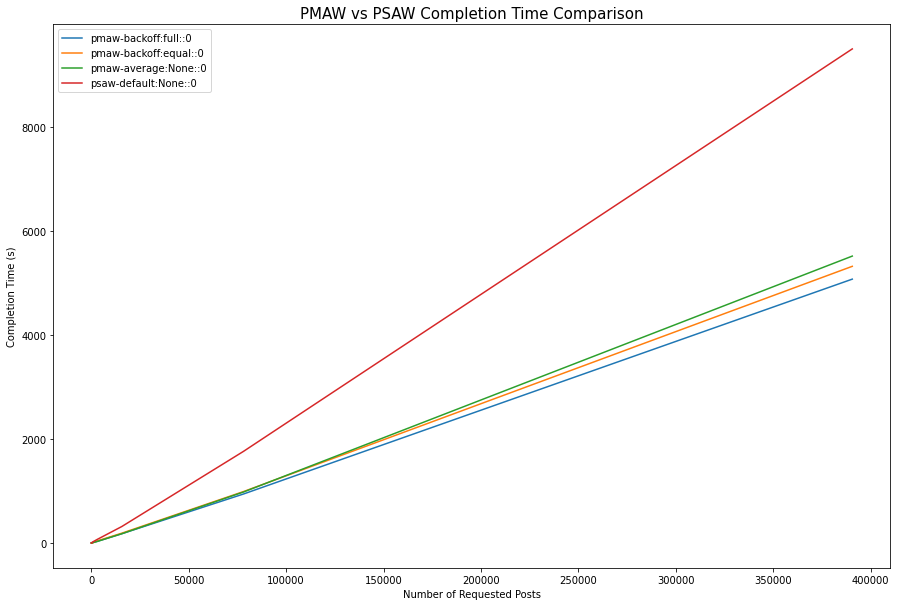

In [112]:
timing_df = pd.DataFrame(bench2.api_timing)
# create name columns
names = []
for row in timing_df.itertuples():
    names.append(f'{row.api}-{row.limit_type}:{row.jitter}::{row.iter}')     
timing_df['name'] = names
names = timing_df['name'].unique()

fig, axes = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)

for name in names:
    x = timing_df.loc[timing_df['name']== name, 'limit']
    y = timing_df.loc[timing_df['name']== name, 'time']
    line, = axes.plot(x, y, label=name)
plt.title('PMAW vs PSAW Completion Time Comparison', fontsize=15)
plt.xlabel('Number of Requested Posts')
plt.ylabel('Completion Time (s)')
axes.legend()
plt.show()

In [133]:
# basic stats at 390625
psaw_t = timing_df.loc[(timing_df['api'] == 'psaw') & (timing_df['limit'] == 390625), 'time'].item()
pmaw_t = timing_df.loc[(timing_df['api'] == 'pmaw') & (timing_df['limit'] == 390625), 'time'].mean()
print(f'PMAW on average was {psaw_t/pmaw_t:.2f}x faster than PSAW when retrieving 390625 posts')
print(f'Retrieving 390625 posts took {psaw_t/3600:.2f}h for PSAW and {pmaw_t/3600:.2f}h on average for PMAW')

PMAW on average was 1.79x faster than PSAW when retrieving 390625 posts
Retrieving 390625 posts took 2.64h for PSAW and 1.47h on average for PMAW


In [135]:
pmaw_df = timing_df.loc[timing_df['api'] == 'pmaw'].copy()
pmaw_df.head(3)

,api,time,limit,results,limit_type,jitter,iter,name
0,pmaw,3.603238,1,1,backoff,full,0,pmaw-backoff:full::0
1,pmaw,3.474622,1,1,backoff,equal,0,pmaw-backoff:equal::0
2,pmaw,2.973867,5,5,backoff,full,0,pmaw-backoff:full::0


In [136]:
# manually extract number of requests
pmaw_df['requests'] = num_requests = [4, 4, 1, 4, 4, 4, 5, 5, 9, 10, 52, 54, 300, 269, 1576, 1704, 8057, 7941, 1, 2, 1, 2, 7, 32, 174, 953, 5311]

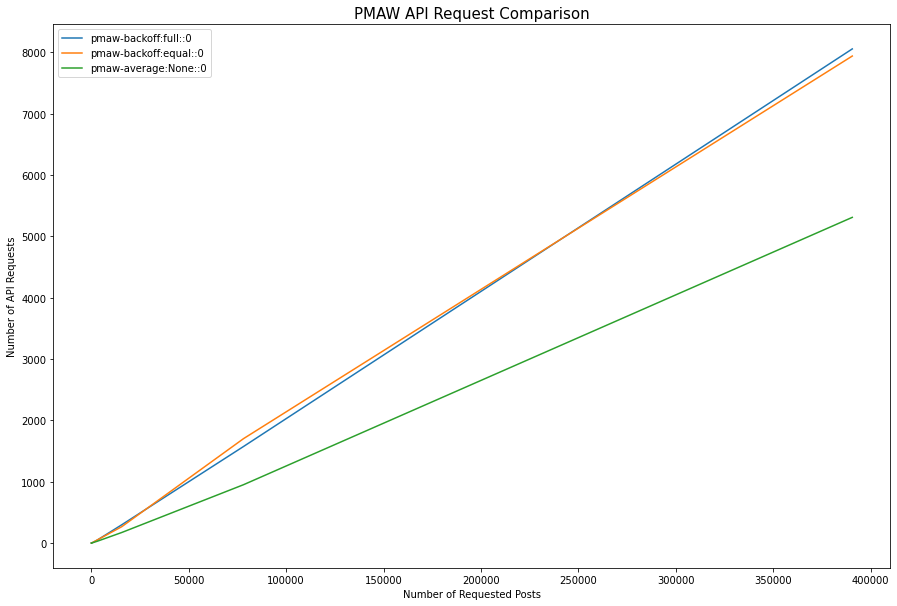

In [137]:
fig, axes = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)

names = pmaw_df['name'].unique()
for name in names:
    x = pmaw_df.loc[timing_df['name']== name, 'limit']
    y = pmaw_df.loc[timing_df['name']== name, 'requests']
    line, = axes.plot(x, y, label=name)
plt.title('PMAW API Request Comparison', fontsize=15)
plt.xlabel('Number of Requested Posts')
plt.ylabel('Number of API Requests')
axes.legend()
plt.show()

In [147]:
# basic stats at 390625
average_r = pmaw_df.loc[(pmaw_df['limit_type'] == 'average') & (pmaw_df['limit'] == 390625), 'requests'].item()
backoff_r = pmaw_df.loc[(pmaw_df['limit_type'] == 'backoff') & (pmaw_df['limit'] == 390625), 'requests'].mean()
print(f'PMAW rate averaging made {100*(backoff_r-average_r)/backoff_r:.2f}% less API requests than exponential backoff')

PMAW rate averaging made 33.60% less API requests than exponential backoff
